In [1]:
import keras
import numpy as np
import librosa
import sys
import numpy
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MODEL = keras.models.load_model("/content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fan.H5")

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/Thesis/bestModel_fan.H5") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
MODEL.summary()

Model: "AEfan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               20608     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 128)               0     

In [7]:

########################################################################

def file_load_stream(wav_name, mono=False):
    try:
        sr = librosa.get_samplerate(wav_name)
        frameSize = sr
        hoplength = frameSize // 2
        stream = librosa.stream(wav_name,
                                block_length=1,
                                frame_length=frameSize,
                                hop_length=hoplength,
                                mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))
    return stream



def file_load(wav_name, mono=False):
    """
    load .wav file.
    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data
    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))
def raw_feature_extractor(audio_path):
  data=file_load(audio_path)
  frequency = data[1] #16khz
  totalLength=len(data[0])#total length = 16khz*10=160000
  sounddata=data[0]*1000
  newvector = []
  for i in range(int(totalLength/160)):
    frame = numpy.asarray(sounddata[160*i:160*(i+1)])
    #frame = numpy.asarray(frame)
    newvector.append(frame)
  return numpy.asarray(newvector)
def get_status(model, threshold, audio_path):
    "Predict status of audio using a trained model"
    data = raw_feature_extractor(audio_path)
    data_predict = []
    errors = numpy.mean(numpy.square(data - MODEL.predict(data)),axis=1)
    pred = numpy.mean(errors)
    if pred >  threshold:
      status = "anomaly"
    else:
      status = "normal" 
    return status

In [5]:
# threshold lấy ở file train
threshold = 57.817585

In [ ]:
file_path = "/content/drive/MyDrive/luanvan/dulieu/fan/test/anomaly_id_00_00000000 (60).wav"
data = raw_feature_extractor(file_path)
predict = MODEL.predict(data)
errors = numpy.mean(numpy.square(data - predict),axis=1)
pred = numpy.mean(errors)
pred

87.926094

In [8]:
file_path = "/content/drive/MyDrive/luanvan/dulieu/fan/test/anomaly_id_00_00000000 (60).wav"
get_status(MODEL, threshold, file_path)

'anomaly'

In [ ]:
!pip install ffmpeg-python

In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
# !sudo apt-get install libportaudio2
# !pip install sounddevice

In [ ]:
import IPython.display as ipd
import sounddevice as sd
import soundfile as sf
import librosa


filename = 'test.wav'
print("Saving.....")
sd.wait()
sf.write(filename, audio, 48000)
print("File saved.")

# ipd.Audio(filename, rate=16000)

Saving.....
File saved.


In [ ]:
# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub

In [ ]:
import torchaudio

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
waveform, sample_rate = torchaudio.load(filename)

new_sample_rate = 16000
new_filename = 'test.wav'

transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
transformed = transform(waveform)

torchaudio.save(new_filename, transformed, new_sample_rate)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)


In [ ]:
# data = file_to_vector_array_stream_test_data(filename)
# errors = numpy.mean(numpy.square(data - MODEL.predict(data)),axis=1)
# pred = numpy.mean(errors)
# pred
get_status(MODEL, threshold, new_filename)

test.wav


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


IndexError: ignored

Sampling rate: 16000 samples/second
Signal size: 88320 samples
Signal duration: 5.520 seconds


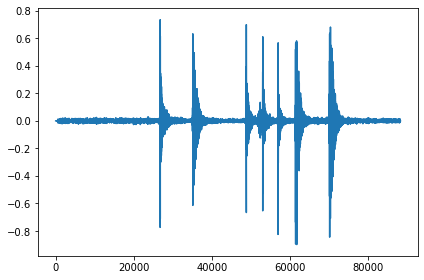

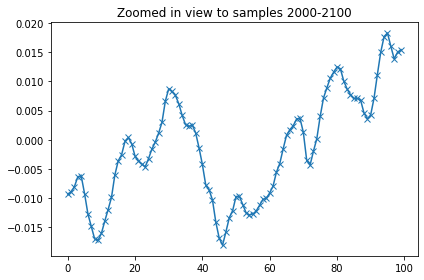

In [ ]:
import matplotlib.pyplot as plt

audio_signal, sampling_rate = sf.read(new_filename)
print('Sampling rate: {} samples/second'.format(sampling_rate))
print('Signal size: {} samples'.format(audio_signal.shape[0]))
print('Signal duration: {:.3f} seconds'.format(audio_signal.shape[0] / sampling_rate))
plt.plot(audio_signal)
plt.tight_layout()
plt.figure()
plt.plot(audio_signal[2000:2100], marker='x')
plt.title('Zoomed in view to samples 2000-2100')
plt.tight_layout()